# One Layered RS Demo

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [193]:
#############################
### TODO REMOVE CONSTRAINTS:
#############################

"""
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- 2 новых товара (юзер никогда не покупал)
- 1 дорогой товар, > 7 долларов
- Все товары из разных категорий (категория - sub_commodity_desc)

- Стоимость каждого рекомендованного товара > 1 доллара
"""
None

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
import re
import time
from lightgbm import LGBMClassifier
import os, sys

from src.metrics import precision_at_k
from implicit.nearest_neighbours import ItemItemRecommender, bm25_weight 
# from src.utils import prefilter_items
# from src.recommenders import MainRecommender


In [206]:
###############################
# Settings && Constants 
###############################

DATA_PATH = './data/retail_train.csv'
TEST_PATH = './data/retail_test1.csv'
ITEM_FEATURES_PATH = './data/product.csv'
USER_FEATURES_PATH = './data/hh_demographic.csv'

TEST_SIZE_WEEKS = (6,3)
N_POPULAR_ITEMS = 4000
INIT_NUM_RECS = 500
N_FIN_RECS = 5
# NUM_THREADS = 8

In [207]:
###############################
# MODULES 
###############################

value_string_template = '\033[91m[[value]]\033[0m'

def prefilter_items(data, take_n_popular=5000, margin_slice_rate=0.9):
    
    """Предфильтрация товаров"""
    
    n_before = value_string_template.replace('[[value]]', str(data['item_id'].nunique()))
    
    
    # drop 0 purchases
    data = data.drop(data[data['quantity']==0].index)
    
    # Calculate price
    data['price'] = data['sales_value'] / data['quantity']
    
    # 1. Drop prices < 1$
    data = data[data['price'] > 1]
    
    # Удаление товаров со средней ценой > 15$
    data = data[data['price'] < 15]
    
    # Уберем товары, которые не продавались за последние 5 месяцев
    purchases_last_week = data.groupby('item_id')['week_no'].max().reset_index()
    weeks = purchases_last_week[
        purchases_last_week['week_no'] > data['week_no'].max() - 5].item_id.tolist()
    data = data[data['item_id'].isin(weeks)]
    
    # Удаление 10% товаров c наименьшей выручкой (сдвигает минимум выручки с 1.1$ до 94.8$ для unsplitted data)
    marginality = data.groupby('item_id')['sales_value'].sum().reset_index()
    ten_percent_slice_idx = int(marginality.shape[0] * margin_slice_rate)

    top_margin = marginality.sort_values('sales_value', ascending=False)[:ten_percent_slice_idx].item_id.tolist()
    data = data[data['item_id'].isin(top_margin)]
    
    # Выбор топ-N самых популярных товаров (N = take_n_popular)
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    top_popular = popularity.sort_values('quantity', ascending=False)[:take_n_popular].item_id.tolist()
    data = data[data['item_id'].isin(top_popular)]
    
    n_after = value_string_template.replace('[[value]]', str(data['item_id'].nunique()))
    print(f"Items variety reduced from: {n_before} to: {n_after} samples...", end='')
    print('\033[94mDone\033[0m')
    
    return data


def get_raw_data_splits(data_path, n_weeks_split=(6, 4), mode=0):
    
    """
    Return data splits depending on mode:
    
    MODE 0: No split
    MODE 1: One level split
    MODE 2: Two level split
    
    data_train: base train split
    data_test: used for lvl 1 validation & lvl 2 train
    data_val: used for lvl 2 validation
    
    for lvl_size_weeks in [6, 3] returns:   
    train_lvl1: week_no (1-85), val_lvl1 & train_lvl2: week_no (86-91), val_lvl2: week_no (92-95)
    """
    print("Preparing raw data...", end='')
    data = pd.read_csv(data_path)
    
    if mode == 0:
        return data
    
    if mode == 1:
        print("Selected one level mode...", end='')
        data_train = data[data['week_no'] < data['week_no'].max() - (n_weeks_split[0] + n_weeks_split[1])]
        data_test = data[(data['week_no'] >= data['week_no'].max() - (n_weeks_split[0] + n_weeks_split[1]))]
        print('\033[94mDone\033[0m') 
        
        return data, data_train, data_test
    
    elif mode == 2:
        print("Selected two level mode...", end='')
        data_train = data[data['week_no'] < data['week_no'].max() - (n_weeks_split[0] + n_weeks_split[1])]
        data_test = data[(data['week_no'] >= data['week_no'].max() /
                               - (n_weeks_split[0] + n_weeks_split[1])) &
                              (data['week_no'] < data['week_no'].max() - (n_weeks_split[1]))]
        data_val_1 = data_test.copy()
        data_val_2 = data[data['week_no'] >= data['week_no'].max() - n_weeks_split[1]] 
        print('\033[94mDone\033[0m') 

        return data, data_train, data_test, data_val_1, data_val_2
    else:
        print('\033[91mError. Mode not understood\033[0m')
        return None

    
def get_price_list(data_1, data_2, _id='item_id', target='price'):
    
    """
    Used 4 creating check dict (price list)
    From all historical data
    Can be used once and stored then updated if needs
    """
    
    pl_1 = data_1.groupby(_id)[target].mean().reset_index()
    pl_2 = data_2.groupby(_id)[target].mean().reset_index()
    d1 = dict(zip(pl_1[_id], pl_1[target]))
    d2 = dict(zip(pl_2[_id], pl_2[target]))
    pl_emb = {**d1, **d2}
    
    return pl_emb


def get_bought_ever_list(data_1, data_2, _id='user_id', target='item_id'):
    
    """
    Used 4 creating check dict (user's ever bought list)
    From all historical data
    Can be used once and stored then updated if needs
    """
    
    pl_1 = data_1.groupby(_id)[target].unique().reset_index()
    pl_2 = data_2.groupby(_id)[target].unique().reset_index()
    d1 = dict(zip(pl_1[_id], pl_1[target]))
    d2 = dict(zip(pl_2[_id], pl_2[target]))
    pl_emb = {**d1, **d2}
    
    return pl_emb


def get_item_commodities_list(feats, _id='item_id', target='sub_commodity_desc_code'):
    
    """
    Used 4 creating check dict (item_id - commodity_type)
    From all historical data
    Can be used once and stored then updated if needs
    """
    
    res = dict(zip(feats[_id], feats[target]))
    return res
        
    
def preprare_features(item_features_path, user_features_path):
    
    """Loads raw item and user features:"""
    
    print("Preparing raw features...", end='')
    item_features = pd.read_csv(item_features_path)
    user_features = pd.read_csv(user_features_path)

    # column processing
    item_features.columns = [col.lower() for col in item_features.columns]
    user_features.columns = [col.lower() for col in user_features.columns]
    item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
    user_features.rename(columns={'household_key': 'user_id'}, inplace=True)
    
    # encode commodities in item_features
    item_features['sub_commodity_desc'] = pd.Categorical(item_features['sub_commodity_desc'])
    item_features['sub_commodity_desc_code'] = item_features['sub_commodity_desc'].cat.codes
    
    print('\033[94mDone\033[0m')
    
    return item_features, user_features



class MainRecommender:
    """Рекоммендации, которые можно получить из ALS
    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, prices, weighting=True):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['sales_value'].count().reset_index()
        self.top_purchases.sort_values('sales_value', ascending=False, inplace=True)

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['sales_value'].count().reset_index()
        self.overall_top_purchases.sort_values('sales_value', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix, self.matrix_index, self.matrix_columns = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.bpr = self.fit_bpr(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
        
        self.item_factors = self.model.item_factors
        self.user_factors = self.model.user_factors
#         self.price_list = prices
        
        self.items_emb_df, self.users_emb_df = self.get_embeddings(self)
        
        
    @staticmethod
    def get_embeddings(self):
        items_emb = self.item_factors
        items_emb_df = pd.DataFrame(items_emb)
        items_emb_df.reset_index(inplace=True)
        items_emb_df['item_id'] = items_emb_df['index'].apply(lambda x: self.id_to_itemid[x])
        items_emb_df = items_emb_df.drop('index', axis=1)

        users_emb = self.user_factors
        users_emb_df = pd.DataFrame(users_emb)
        users_emb_df.reset_index(inplace=True)
        users_emb_df['user_id'] = users_emb_df['index'].apply(lambda x: self.id_to_userid[x])
        users_emb_df = users_emb_df.drop('index', axis=1)

        return items_emb_df, users_emb_df
        

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', 
                                          columns='item_id',
                                          values='quantity',
                                          aggfunc='count',
                                          fill_value=0
                                          )
        matrix_index = user_item_matrix.index
        matrix_columns = user_item_matrix.columns

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit
        return user_item_matrix, matrix_index, matrix_columns
    

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id
    

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
        
        own_recommender = ItemItemRecommender(K=1)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        return own_recommender
    

    @staticmethod
    def fit(user_item_matrix, n_factors=32, regularization=0.001, iterations=20, num_threads=8):
        
        """Обучает ALS"""
        
        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        return model
    
    @staticmethod
    def fit_bpr(user_item_matrix, n_factors=31, regularization=0.001, iterations=20, num_threads=8):
        model = BayesianPersonalizedRanking(factors=n_factors,
                                             regularization=regularization,
                                             iterations=iterations,
                                             num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        return model

    def _update_dict(self, user_id):
        
        """Если появился новый user / item, то нужно обновить словари"""
        
        if user_id not in self.userid_to_id.keys():
            print(f"user_id: '\033[94m{user_id}\033[0m' not in dict, add...")
            max_id = max(list(self.userid_to_id.values()))
            max_id += 1
            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})
            

    def _get_similar_item(self, item_id):
        
        """Находит товар, похожий на item_id"""
        
        # Товар похож на себя -> рекомендуем 2 товара
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]
    

    def _extend_with_top_popular(self, recommendations, N=5):
        
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""
        
        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]
        return recommendations
    

    def _get_recommendations(self, user, model, N=5):
        
        """Рекомендации через стардартные библиотеки implicit"""
        
        
        if user not in self.userid_to_id.keys():
            self._update_dict(user_id=user)
            res = []
            res = self._extend_with_top_popular(res, N=N)
        else:
        
        
            res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                            user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                            N=N,
                                            filter_already_liked_items=False,
                                            filter_items=None,
                                            recalculate_user=True)]
            res = self._extend_with_top_popular(res, N=N)
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res
    

    def get_als_recommendations(self, user, N=5):
        
        """Рекомендации через стардартные библиотеки implicit"""
        
#         self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)
    
    def get_bayesian_recommendations(self, user, N=5):
        return self._get_recommendations(user, model=self.bpr, N=N)

    def get_own_recommendations(self, user, N=5):
        
        """Рекомендуем товары среди тех, которые юзер уже купил"""
        
#         self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)
    

    def get_similar_items_recommendation(self, user, N=5):
        
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        
        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res
    

    def get_similar_users_recommendation(self, user, N=5):
        
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
        
        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = [rec[0] for rec in similar_users]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))


        res = self._extend_with_top_popular(res, N=N)
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res
    
    
def check_valid_items(res,
                      user,
                      item_to_commodity,
                      itemid_to_price,
                      user_bought_history,
                      n=5,
                      max_price_constraint=7,
                      max_n_new_items_constraint=2
                     ):
    
    """
    Constraints Checker Module.
    Check commended items for user.
    Input: res:array with len=n
    Return: error flag, one-hot encodded errors
    """
    
    # res: list result of n=5 elements
    
    err_flag = 0  # error flag
    err_pos = np.zeros(len(res))  # penalty weights for items to change positions
    user_history = user_bought_history[user][:10]  # user purchases of unique items history
    price_checklist = np.zeros(len(res))  # price list for checking conditions
    unique_checklist = np.zeros(len(res))  # unique item positions counter
    
    c = []
    for i, item in enumerate(res):
        commodity = item_to_commodity[item]
        price_checklist[i] = itemid_to_price[item]        
        
        # check if code already exists in recs. If true change first duplicate
        if commodity in c:
            err_flag = 1
            err_pos[i] += 1  # add penalty for mismatch element position
            
        # keep track of unique items
        if item not in user_history:
            unique_checklist[i] = 1
        c.append(commodity)
        
    max_price = price_checklist[np.argmax(price_checklist)]
    
    # if no expensive items in list, mark last element
    if max_price < max_price_constraint:
        err_flag = 1
        
        # add penalty to last highest element
        #  len(res-1) - np.argmax(err_pos[::-1]) keeps track on the last element if equal weights exist like 0
        #  used in case of ranked elements
        err_pos[len(res)-1 - np.argmax(err_pos[::-1])] += 1
    
    # if not enough unique elements, mark last element
    if unique_checklist.sum() < max_n_new_items_constraint:
        err_flag = 1
        # add penalty to last highest element
        err_pos[len(res)-1 - np.argmax(err_pos[::-1])] += 1
    
    return err_flag, err_pos

            

def postfilter_items(data,
                     pop_recs,
                     item_to_commodity,
                     itemid_to_price,
                     user_bought_history,
                     n=5,
                     target_col='base_rec',
                     res_col='result'
                    ):    
    
    """
    Input: user recommendations: pd.DataFrame
    """
    # make result placeholders
    data[res_col] = np.nan
    data[res_col] = data[res_col].astype('object')
    
    
    for index, row in data.iterrows():       
        if row.user_id %500==0:
            print(f"iter on {row.user_id}")
        
        recs = row[target_col]
        result = recs[:n] # list with n item_id recs
        flag, err_positions = check_valid_items(result,
                                                row.user_id,
                                                item_to_commodity,
                                                itemid_to_price,
                                                user_bought_history,
                                                n)

        take_from_pos = n + 1  # set initial position of new element to substitute as next # after existing recs
        ov=1
        while flag:
            
            pos_list = np.where(err_positions>0)[0]  # invalid element positions pointer
            # change each invalid element 
            for pos in pos_list:
                if take_from_pos%INIT_NUM_RECS==0 and not ov:  # INIT_NUM_RECS
#                     print(take_from_pos)
                    take_from_pos = 1
                    ov=1
                    
                if ov:
                    result[pos] = pop_recs[take_from_pos]
                    take_from_pos +=1
                    
                else:
                    result[pos] = recs[take_from_pos]
                    take_from_pos +=1
                
            # check new recommendations
            flag, err_positions = check_valid_items(result,
                                                row.user_id,
                                                item_to_commodity,
                                                itemid_to_price,
                                                user_bought_history,
                                                n)        
                    
        data.at[index, res_col] = result
    return data



def money_precision_at_k(recommended_list, bought_list, prices, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])
    
    prices_recommended = np.array([prices[i] for i in recommended_list])
    prices_bought = np.array([prices[i] for i in bought_list])
    
    flags = np.isin(bought_list, recommended_list)
    precision = np.dot(flags, prices_bought) / np.dot(np.ones(k), prices_recommended)
    
    
    return precision

In [208]:
%%time

data_train_lvl_1 = get_raw_data_splits(DATA_PATH, mode=0)
data_val_lvl_1 = get_raw_data_splits(TEST_PATH, mode=0)

# TWO LVL PREPARATION

# data, data_train_lvl_1, data_val_lvl_1, data_train_lvl_2, data_val_lvl_2 = get_raw_data_splits(
#     DATA_PATH, TEST_SIZE_WEEKS, mode=1)

item_features, user_features = preprare_features(ITEM_FEATURES_PATH, USER_FEATURES_PATH)

Preparing raw data...Preparing raw data...Preparing raw features...Done
Wall time: 4.19 s


In [209]:
# Prefilter routine
data_train_lvl_1 = prefilter_items(data_train_lvl_1, N_POPULAR_ITEMS) # Prefilter routine

data_val_lvl_1 = prefilter_items(data_val_lvl_1, N_POPULAR_ITEMS) # Prefilter routine

Items variety reduced from: 89051 to: 4000 samples...Done
Items variety reduced from: 20497 to: 4000 samples...Done


In [210]:
%%time

# Get avg historical prices for all products
itemid_to_price = get_price_list(data_train_lvl_1, data_val_lvl_1)
user_bought_history = get_bought_ever_list(data_train_lvl_1, data_val_lvl_1)
item_to_commodity =  get_item_commodities_list(item_features)

# data.groupby('item_id')['sales_value'].sum().reset_index()

Wall time: 1.5 s


In [211]:
%%time

recommender = MainRecommender(data_train_lvl_1, itemid_to_price)

UnboundLocalError: local variable 'vali_item_users' referenced before assignment

In [119]:
%%time

result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1['base_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=INIT_NUM_RECS))

user_id: '1176' not in dict, add...
user_id: '2325' not in dict, add...
Wall time: 20.5 s


In [120]:
%%time
result_lvl_1 = postfilter_items(result_lvl_1,
                            recommender.overall_top_purchases,
                            item_to_commodity,
                            itemid_to_price,
                            user_bought_history,
                            n=N_FIN_RECS)

iter on 1000
iter on 1500
iter on 2500
Wall time: 7.17 s


In [121]:
res = result_lvl_1.apply(lambda row: money_precision_at_k(row['result'], row['actual'], itemid_to_price, k=5), axis=1).mean()
res

0.0346839625861094

Results:

1 lvl. als recommender: current max: 0.77
- Train 1 lvl split. No features, ignore new, ignore restrictions (week_no 1-85, 86-91). Result metric: 0.6
- Train 1 lvl split. No features, ignore new, ignore restrictions (week_no 1-85, 86-95). Result metric: 0.19
- =same=... recs for new users by popular items. Result metric: 0.177
- Public-test validation (week_no 1-95, 96-98), pop-recs filling, ignore restrictions. Result metric: 0.1
- =same=... Follow restrictions (replace from als rec list, then popular). Result metric: 0.07
- =same=... Follow restrictions (replace from popular rec list, then popular). Result metric: 0.06
- =same=... Prefilter workout: skip old purchased goods. Result metric 0.078
- change popular recomendations to price, change weights at user-item matrix. Result metric 0.034
- 1 lvl. own recommender. Result metric: 0.1


In [203]:
def eval_routine(DATA_PATH,
                 TEST_PATH,
                 ITEM_FEATURES_PATH,
                 USER_FEATURES_PATH,
                 TEST_SIZE_WEEKS,
                 N_POPULAR_ITEMS,
                 INIT_NUM_RECS,
                 N_FIN_RECS):
    
    data_train_lvl_1 = get_raw_data_splits(DATA_PATH, mode=0)
    data_val_lvl_1 = get_raw_data_splits(TEST_PATH, mode=0)
    item_features, user_features = preprare_features(ITEM_FEATURES_PATH, USER_FEATURES_PATH)
    data_train_lvl_1 = prefilter_items(data_train_lvl_1, N_POPULAR_ITEMS) # Prefilter routine
    data_val_lvl_1 = prefilter_items(data_val_lvl_1, N_POPULAR_ITEMS) # Prefilter routine
    itemid_to_price = get_price_list(data_train_lvl_1, data_val_lvl_1)
    user_bought_history = get_bought_ever_list(data_train_lvl_1, data_val_lvl_1)
    item_to_commodity =  get_item_commodities_list(item_features)
    recommender = MainRecommender(data_train_lvl_1, itemid_to_price)
    result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_1.columns=['user_id', 'actual']
    result_lvl_1['base_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_bayesian_recommendations(x, N=INIT_NUM_RECS))
    result_lvl_1 = postfilter_items(result_lvl_1,
                            recommender.overall_top_purchases,
                            item_to_commodity,
                            itemid_to_price,
                            user_bought_history,
                            n=N_FIN_RECS)
    res = result_lvl_1.apply(lambda row: money_precision_at_k(row['result'],
                                                              row['actual'],
                                                              itemid_to_price,
                                                              k=5), axis=1).mean()
    return res

In [161]:
# DATA_PATH = './data/retail_train.csv'
# TEST_PATH = './data/retail_test1.csv'
# ITEM_FEATURES_PATH = './data/product.csv'
# USER_FEATURES_PATH = './data/hh_demographic.csv'

# TEST_SIZE_WEEKS = (6,3)
N_POPULAR_ITEMS = np.arange(5000,10000, 500)
# INIT_NUM_RECS = 300
# N_FIN_RECS = 5

eval_metrics = []
for num in N_POPULAR_ITEMS:


    res = eval_routine(DATA_PATH,
                       TEST_PATH,
                       ITEM_FEATURES_PATH,
                       USER_FEATURES_PATH,
                       TEST_SIZE_WEEKS,
                       num,
                       INIT_NUM_RECS,
                       N_FIN_RECS)

    eval_metrics.append(res)

Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 5000 samples...Done
Items variety reduced from: 20497 to: 5000 samples...Done



user_id: '1043' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 5500 samples...Done
Items variety reduced from: 20497 to: 5500 samples...Done



user_id: '1043' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 6000 samples...Done
Items variety reduced from: 20497 to: 6000 samples...Done



user_id: '650' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2325' not in dict, add...
user_id: '2364' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 6500 samples...Done
Items variety reduced from: 20497 to: 6500 samples...Done



user_id: '650' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2325' not in dict, add...
user_id: '2364' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 7000 samples...Done
Items variety reduced from: 20497 to: 7000 samples...Done



user_id: '1043' not in dict, add...
user_id: '2120' not in dict, add...
user_id: '2325' not in dict, add...
user_id: '2364' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 7500 samples...Done
Items variety reduced from: 20497 to: 7500 samples...Done



user_id: '75' not in dict, add...
user_id: '729' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2120' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 8000 samples...Done
Items variety reduced from: 20497 to: 8000 samples...Done



user_id: '75' not in dict, add...
user_id: '729' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2120' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 8500 samples...Done
Items variety reduced from: 20497 to: 8500 samples...Done



user_id: '75' not in dict, add...
user_id: '729' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2120' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 9000 samples...Done
Items variety reduced from: 20497 to: 9000 samples...Done



user_id: '75' not in dict, add...
user_id: '729' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2120' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500
Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 9500 samples...Done
Items variety reduced from: 20497 to: 9500 samples...Done



user_id: '75' not in dict, add...
user_id: '729' not in dict, add...
user_id: '1043' not in dict, add...
user_id: '2120' not in dict, add...
user_id: '2325' not in dict, add...
iter on 1000
iter on 1500
iter on 2500


In [ ]:
res

In [162]:
N_POPULAR_ITEMS

array([5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500])

In [163]:
eval_metrics

[0.08377515550926759,
 0.08363650737998349,
 0.08294430072744367,
 0.08489296216950801,
 0.08527922406141984,
 0.08690208768033132,
 0.08737717664481394,
 0.0852363340022869,
 0.0849502905032737,
 0.08372449581736492]

In [164]:
x = np.array([1000, 1500, 2000, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500])
y = np.array([
    0.07859617320340956, 0.07756664938334809, 0.0773187229745913, 0.07971259054182002,
    0.08331703394679879, 0.08449291305737293, 0.08397684265847496, 0.08377515550926759,
    0.08363650737998349, 0.08294430072744367,0.08489296216950801, 0.08527922406141984,
    0.08690208768033132, 0.08737717664481394, 0.0852363340022869, 0.0849502905032737,
    0.08372449581736492
])

''

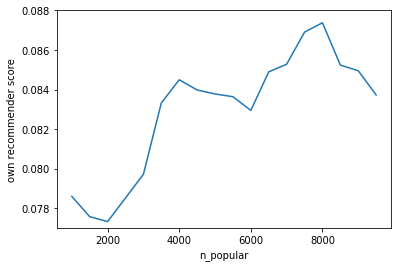

In [173]:
plt.plot(x, y)
plt.xlabel('n_popular')
plt.ylabel('own recommender score')
plt.ylim(0.077, 0.088)
;

In [204]:
res = eval_routine(DATA_PATH,
                   TEST_PATH,
                   ITEM_FEATURES_PATH,
                   USER_FEATURES_PATH,
                   TEST_SIZE_WEEKS,
                   N_POPULAR_ITEMS,
                   INIT_NUM_RECS,
                   N_FIN_RECS)
res  # 0.10219570957759051   # 0.09726113193877858

Preparing raw data...Preparing raw data...Preparing raw features...Done
Items variety reduced from: 89051 to: 4000 samples...Done
Items variety reduced from: 20497 to: 4000 samples...Done


UnboundLocalError: local variable 'vali_item_users' referenced before assignment